# KC immediate anti-trend strat

In [1]:
from binance.client import Client
from downloader import Downloader
import matplotlib.pyplot as plt
dl = Downloader()
import pandas as pd
import time
from datetime import datetime
import numpy as np
import statsmodels.formula.api as sm
import math
import seaborn as sns
import metalabeller as ml
import ta
import macdtester as t

In [10]:
df = dl.get_working_data("ATOMUSDT", span="h")

In [11]:
def get_kc(high, low, close, kc_lookback, multiplier, atr_lookback):
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift()))
    tr3 = pd.DataFrame(abs(low - close.shift()))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(alpha = 1/atr_lookback).mean()
    
    kc_middle = close.ewm(kc_lookback).mean()
    kc_upper = close.ewm(kc_lookback).mean() + multiplier * atr
    kc_lower = close.ewm(kc_lookback).mean() - multiplier * atr
    
    return kc_middle, kc_upper, kc_lower
    

In [12]:
df['kc_middle'], df['kc_upper'], df['kc_lower'] = get_kc(df.high, df.low, df.close, 20, 2, 10)

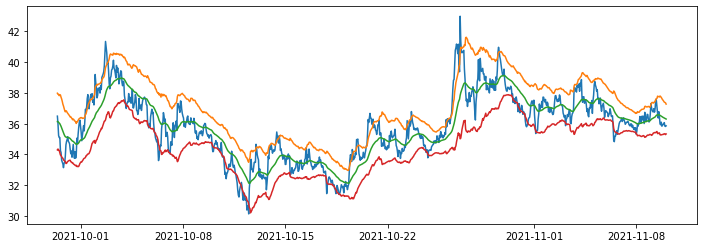

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))
df_ = df[-1000:]
ax.plot(df_.close)
ax.plot(df_.kc_upper)
ax.plot(df_.kc_middle)
ax.plot(df_.kc_lower)

In [26]:
df_ = df.rename(columns={"open":"o", "high":"h", "low":"l", "close":"c", 
                         "volume":"v", "kc_middle":"m", "kc_upper":"u", "kc_lower":"b"})

In [27]:
df_s = df_.shift()

In [28]:
c_up = df_[(df_.h>df_.u) & (df_s.h<df_.u)]
c_down = df_[(df_.l<df_.b) & (df_s.l>df_.b)]

In [30]:
c_down

,o,h,l,c,v,m,u,b
timestamp,,,,,,,,
2019-05-05 12:00:00,4.861,4.972,4.774,4.951,110263.903,5.025741,5.271616,4.779866
2019-05-06 00:00:00,4.838,4.857,4.756,4.781,37155.808,4.961877,5.157540,4.766214
2019-05-06 02:00:00,4.822,4.830,4.662,4.696,60375.341,4.943003,5.168930,4.717076
2019-05-07 14:00:00,4.744,4.749,4.620,4.621,105393.578,4.827235,5.022601,4.631869
2019-05-07 23:00:00,4.698,4.714,4.590,4.596,55564.166,4.783393,4.961120,4.605665
...,...,...,...,...,...,...,...,...
2021-11-03 12:00:00,36.790,37.500,35.480,36.040,412315.840,36.873260,38.183939,35.562580
2021-11-06 10:00:00,36.510,36.640,35.840,35.870,103906.740,37.010252,37.985299,36.035204
2021-11-06 11:00:00,35.860,35.860,34.170,34.900,421978.060,36.909763,38.127306,35.692221


In [69]:
events = pd.DataFrame(np.nan, index=c_down.index, columns=["ret", "t1"])
for i in c_down.index:
    row = c_down.loc[i]
    df_ = df.loc[i:i+pd.Timedelta(days=3)]
    dist = row.m-row.b
    tp, sl = 0, 0
    try: tp = df_[df_.high>row.b+0.5*dist].index[0]
    except: tp=df.index[-1]
    try: sl = df_[df_.low<row.b-0.5*dist].index[0]
    except: sl = df.index[-1]
#     print(f"=={tp}, {sl}==")
    if tp>sl: 
        events.loc[i] = {"ret":-1, "t1":sl}
    elif sl>tp: 
        events.loc[i] = {"ret":1, "t1":tp}
    else: 
        events.loc[i] = {"ret":0, "t1":i}
    
        

In [70]:
events

,ret,t1
timestamp,,
2019-05-05 12:00:00,1.0,2019-05-05 12:00:00
2019-05-06 00:00:00,1.0,2019-05-06 01:00:00
2019-05-06 02:00:00,-1.0,2019-05-06 03:00:00
2019-05-07 14:00:00,1.0,2019-05-07 14:00:00
2019-05-07 23:00:00,1.0,2019-05-07 23:00:00
...,...,...
2021-11-03 12:00:00,1.0,2021-11-03 12:00:00
2021-11-06 10:00:00,1.0,2021-11-06 10:00:00
2021-11-06 11:00:00,-1.0,2021-11-06 11:00:00


In [71]:
events.ret.value_counts()

 1.0    527
-1.0    305
 0.0     47
Name: ret, dtype: int64